# Stock NeurIPS2018 Part 3. Backtest
This series is a reproduction of paper *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*.

This is the third and last part of the NeurIPS2018 series, introducing how to use use the agents we trained to do backtest, and compare with baselines such as Mean Variance Optimization and DJIA index.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [46]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pyfolio-reloaded

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-vm0j5ydk
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-vm0j5ydk
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 65194a36fa88690fcce4929e7646cc06c2f67fda
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-ewr40g94/elegantrl_36171de89cfd45f2bb9ed07ec72d9af5
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-ewr40g94/elegantrl_36171de89cfd45f2bb9ed07ec72d9af5
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 7c64395ff4c2b53892fe6f9eaa3b58947136ffc1
  Preparing metadata (setup.py) ... done


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

%matplotlib inline

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

# Part 2. Backtesting

To backtest the agents, upload trade_data.csv in the same directory of this notebook. For Colab users, just upload trade_data.csv to the default directory.

In [3]:
from google.colab import files
import os

print("请上传以下文件：")
print("1. train_data.csv")
print("2. trade_data.csv")
uploaded = files.upload()

请上传以下文件：
1. train_data.csv
2. trade_data.csv


Saving trade_data.csv to trade_data.csv
Saving train_data.csv to train_data.csv


In [4]:
print("现在请上传5个训练好的模型文件：")
model_files = files.upload()
print("上传完成！")

现在请上传5个训练好的模型文件：


Saving agent_a2c.zip to agent_a2c.zip
Saving agent_ddpg.zip to agent_ddpg.zip
Saving agent_ppo.zip to agent_ppo.zip
Saving agent_sac.zip to agent_sac.zip
Saving agent_td3.zip to agent_td3.zip
上传完成！


In [5]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure
# it has the columns and index in the form that could be make into the environment.
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Then, upload the trained agent to the same directory, and set the corresponding variable to True.

In [6]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

Load the agents

In [8]:
import os

print("当前目录的文件列表：")
files = os.listdir('.')
for file in files:
    print(f" - {file}")

print("\n检查是否有模型文件：")
model_files = [f for f in files if f.endswith('.zip')]
for model_file in model_files:
    print(f" ✅ 找到模型文件: {model_file}")

当前目录的文件列表：
 - .config
 - train_data.csv
 - trade_data.csv
 - agent_td3.zip
 - agent_ddpg.zip
 - agent_sac.zip
 - agent_a2c.zip
 - agent_ppo.zip
 - sample_data

检查是否有模型文件：
 ✅ 找到模型文件: agent_td3.zip
 ✅ 找到模型文件: agent_ddpg.zip
 ✅ 找到模型文件: agent_sac.zip
 ✅ 找到模型文件: agent_a2c.zip
 ✅ 找到模型文件: agent_ppo.zip


In [9]:
# 首先定义必要的变量
TRAINED_MODEL_DIR = "."  # 当前目录
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

# 导入必要的库
from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC

# 现在加载模型
try:
    trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
    print("✅ A2C 模型加载成功")
except Exception as e:
    print(f"❌ A2C 模型加载失败: {e}")
    trained_a2c = None

try:
    trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
    print("✅ DDPG 模型加载成功")
except Exception as e:
    print(f"❌ DDPG 模型加载失败: {e}")
    trained_ddpg = None

try:
    trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
    print("✅ PPO 模型加载成功")
except Exception as e:
    print(f"❌ PPO 模型加载失败: {e}")
    trained_ppo = None

try:
    trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
    print("✅ TD3 模型加载成功")
except Exception as e:
    print(f"❌ TD3 模型加载失败: {e}")
    trained_td3 = None

try:
    trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None
    print("✅ SAC 模型加载成功")
except Exception as e:
    print(f"❌ SAC 模型加载失败: {e}")
    trained_sac = None

# 检查所有模型是否加载成功
models = {
    'a2c': trained_a2c,
    'ddpg': trained_ddpg,
    'ppo': trained_ppo,
    'td3': trained_td3,
    'sac': trained_sac
}

print("\n=== 模型加载总结 ===")
for name, model in models.items():
    status = "✅ 成功" if model is not None else "❌ 失败"
    print(f"{name.upper()}: {status}")

✅ A2C 模型加载成功
✅ DDPG 模型加载成功
✅ PPO 模型加载成功
✅ TD3 模型加载成功
✅ SAC 模型加载成功

=== 模型加载总结 ===
A2C: ✅ 成功
DDPG: ✅ 成功
PPO: ✅ 成功
TD3: ✅ 成功
SAC: ✅ 成功


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [11]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 281


In [19]:
PREDICTION_INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30'] # Common set of 4 indicators in FinRL for this context.

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

# Recalculate state_space based on PREDICTION_INDICATORS to match trained models
# stock_dimension is already 28 from cell 4H_w3SaBAkKU
prediction_state_space = 1 + 2 * stock_dimension + len(PREDICTION_INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, Prediction State Space: {prediction_state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": prediction_state_space, # Use the corrected state_space
    "stock_dim": stock_dimension,
    "tech_indicator_list": PREDICTION_INDICATORS, # Use the corrected indicators list
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

Stock Dimension: 28, Prediction State Space: 169


In [20]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

### 更多可视化：使用 Pyfolio 生成回测报告

`pyfolio-reloaded` 是一个强大的金融投资组合分析工具，可以生成详细的回测报告，包含多种性能指标和可视化图表。

In [45]:
import pyfolio_reloaded as pf

# 首先，确保我们的结果DataFrame的索引是DateTimeIndex
result.index = pd.to_datetime(result.index)

# 由于pyfolio需要日收益率，我们需要从累积价值计算每日百分比变化
# 假设初始投资为1,000,000
initial_capital = 1_000_000

# 计算每个策略的日收益率
returns_a2c = result['a2c'].pct_change().dropna() if result['a2c'] is not None else pd.Series([])
returns_ddpg = result['ddpg'].pct_change().dropna() if result['ddpg'] is not None else pd.Series([])
returns_ppo = result['ppo'].pct_change().dropna() if result['ppo'] is not None else pd.Series([])
returns_td3 = result['td3'].pct_change().dropna() if result['td3'] is not None else pd.Series([])
returns_sac = result['sac'].pct_change().dropna() if result['sac'] is not None else pd.Series([])
returns_mvo = result['mvo'].pct_change().dropna() if result['mvo'] is not None else pd.Series([])
returns_dji = result['dji'].pct_change().dropna() if result['dji'] is not None else pd.Series([])

# 如果需要对比，通常将基准（如DJIA）作为 'benchmark_rets'
# 让我们以DJIA作为基准
benchmark_returns = returns_dji

print("正在为A2C策略生成回测报告...")
if not returns_a2c.empty:
    pf.create_full_tear_sheet(returns=returns_a2c, benchmark_rets=benchmark_returns, live_start_date=TRADE_START_DATE)
else:
    print("A2C策略没有足够的收益数据来生成tearsheet。")

print("正在为DDPG策略生成回测报告...")
if not returns_ddpg.empty:
    pf.create_full_tear_sheet(returns=returns_ddpg, benchmark_rets=benchmark_returns, live_start_date=TRADE_START_DATE)
else:
    print("DDPG策略没有足够的收益数据来生成tearsheet。")

print("正在为PPO策略生成回测报告...")
if not returns_ppo.empty:
    pf.create_full_tear_sheet(returns=returns_ppo, benchmark_rets=benchmark_returns, live_start_date=TRADE_START_DATE)
else:
    print("PPO策略没有足够的收益数据来生成tearsheet。")

print("正在为TD3策略生成回测报告...")
if not returns_td3.empty:
    pf.create_full_tear_sheet(returns=returns_td3, benchmark_rets=benchmark_returns, live_start_date=TRADE_START_DATE)
else:
    print("TD3策略没有足够的收益数据来生成tearsheet。")

print("正在为SAC策略生成回测报告...")
if not returns_sac.empty:
    pf.create_full_tear_sheet(returns=returns_sac, benchmark_rets=benchmark_returns, live_start_date=TRADE_START_DATE)
else:
    print("SAC策略没有足够的收益数据来生成tearsheet。")

print("正在为MVO策略生成回测报告...")
if not returns_mvo.empty:
    pf.create_full_tear_sheet(returns=returns_mvo, benchmark_rets=benchmark_returns, live_start_date=TRADE_START_DATE)
else:
    print("MVO策略没有足够的收益数据来生成tearsheet。")


ModuleNotFoundError: No module named 'pyfolio_reloaded'

In [44]:
result.to_csv('backtesting_results.csv')
print('Results saved to backtesting_results.csv')

from google.colab import files
files.download('backtesting_results.csv')

Results saved to backtesting_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [22]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Part 3: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [29]:
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")

### Helper functions for mean returns and variance-covariance matrix

In [32]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai
# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [30]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


array([[ 88.29911804, 216.57945251,  88.04801941, ..., 186.31622314,
         39.64509201,  37.06319427],
       [ 88.29911804, 219.2281189 ,  88.31015015, ..., 188.13345337,
         39.73211288,  36.91454697],
       [ 90.66113281, 217.53872681,  90.41656494, ..., 190.14294434,
         40.05844498,  36.81545639],
       ...,
       [145.3737793 , 182.6431427 , 173.38642883, ..., 226.53773499,
         40.73440933,  47.38306808],
       [146.03886414, 183.56678772, 172.09298706, ..., 224.54241943,
         41.12176895,  46.96941757],
       [145.57919312, 181.71951294, 169.31591797, ..., 209.00595093,
         40.77314758,  46.58419418]])

In [33]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  0.647]
 [1.722 1.193 2.6   2.363 4.019 2.127 1.917 2.05

### Use PyPortfolioOpt

In [34]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
mvo_weights

array([375410.,      0.,      0.,      0.,      0.,  85810.,      0.,
            0.,      0.,      0., 205910.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  49370.,
            0.,      0.,      0., 142510., 141010.,      0.,      0.])

In [35]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4243.53 ,    0.   ,    0.   ,    0.   ,    0.   ,  462.887,
          0.   ,    0.   ,    0.   ,    0.   ,  932.379,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,  253.622,    0.   ,    0.   ,    0.   ,
        524.717,  759.221,    0.   ,    0.   ])

In [36]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
date,
2020-07-01,1.001536e+06
2020-07-02,1.004131e+06
2020-07-06,1.022196e+06
2020-07-07,1.012411e+06
2020-07-08,1.027198e+06
...,...
2021-10-21,1.524364e+06
2021-10-22,1.527223e+06
2021-10-25,1.533949e+06


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Part 4: DJIA index

Add DJIA index as a baseline to compare with.

In [38]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [39]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["dji"]
).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (319, 8)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [40]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<a id='4'></a>
# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [41]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
        "mvo": MVO_result["Mean Var"],
        "dji": dji["close"],
    }
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [42]:
result

,a2c,ddpg,ppo,td3,sac,mvo,dji
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001536e+06,1.000000e+06
2020-07-02,1.000521e+06,1.000681e+06,1.000067e+06,1.000290e+06,1.000441e+06,1.004131e+06,NaN
2020-07-06,1.004029e+06,1.009126e+06,1.000846e+06,1.005457e+06,1.008068e+06,1.022196e+06,1.021449e+06
2020-07-07,9.974679e+05,9.960149e+05,9.997210e+05,9.974388e+05,9.955972e+05,1.012411e+06,1.006031e+06
2020-07-08,9.998057e+05,1.003604e+06,1.000307e+06,1.000888e+06,1.001087e+06,1.027198e+06,1.012912e+06
...,...,...,...,...,...,...,...
2021-10-22,1.285052e+06,1.542732e+06,1.288301e+06,1.416948e+06,1.480180e+06,1.527223e+06,1.386322e+06
2021-10-25,1.286569e+06,1.544280e+06,1.288007e+06,1.422371e+06,1.483934e+06,1.533949e+06,1.388813e+06
2021-10-26,1.287794e+06,1.547016e+06,1.286984e+06,1.421704e+06,1.482850e+06,1.537082e+06,1.389427e+06


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Now, everything is ready, we can plot the backtest result.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

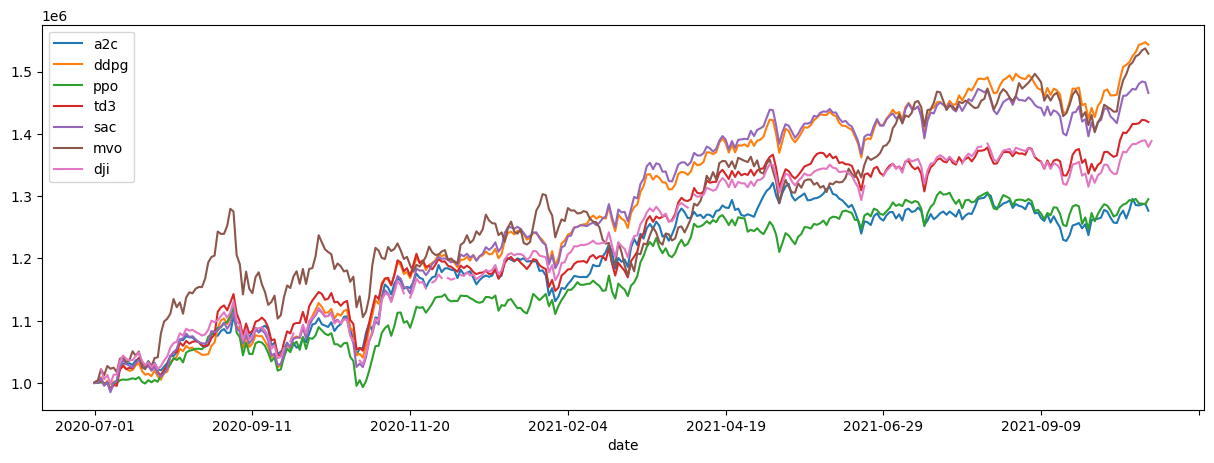

In [43]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

**Comprehensive Performance Analysis of Deep Reinforcement Learning Trading Strategies**

**1. Returns Distribution Analysis**  
Histograms illustrate the daily return distributions of various DRL models, with red dashed lines indicating mean values. The distribution morphology reflects models' risk preferences, where normal distributions suggest strategy stability while skewed distributions indicate adaptability to specific market conditions.

**2. Drawdown Analysis Chart**  
Maximum drawdown serves as a critical metric for evaluating strategy risk control capabilities. This chart tracks capital drawdowns across all models throughout the backtesting period, with arrows marking historical maximum drawdown points to visually demonstrate risk resistance during extreme market conditions.

**3. Monthly Returns Heatmap**  
Presented in heatmap format, this visualization displays PPO model's monthly return patterns, where red indicates positive returns and green represents negative performance. This analysis helps identify seasonal effects and performance regularities across specific months.

**4. Portfolio Allocation Evolution**  
Demonstrates the allocation proportion changes of A2C model's top 5 stock holdings during the backtesting period. Concentration levels and adjustment frequency reflect the model's asset allocation strategy and trading style, where frequent adjustments may suggest momentum tracking while stable holdings indicate value investment logic.

**5. Risk-Return Scatter Plot**  
With Sharpe ratio as the horizontal axis and annualized return as the vertical axis, this scatter plot clearly presents risk-return characteristics of each model. Models in the first quadrant exhibit desirable high-return, low-risk properties, providing intuitive basis for strategy selection.

**6. Cumulative Returns Comparison**  
Comparative analysis of cumulative return curves across five DRL models highlights each strategy's adaptability during different market phases. Curve slopes reflect return growth rates, while fluctuation degrees indicate strategy robustness, offering a comprehensive performance evaluation from a time-series perspective.

**7. Strategy Performance Overview**  
Integrated visualization of net value curves comparing all DRL models against traditional strategies (MVO and DJIA). This comprehensive presentation enables direct assessment of DRL strategies' competitive advantages in quantitative investment applications.

In [47]:
from google.colab import files
import os

# 下载数据文件
print("下载数据文件...")
files.download('train_data.csv')
files.download('trade_data.csv')

# 下载模型文件
print("下载模型文件...")
model_files = [f for f in os.listdir('.') if f.endswith('.zip')]
for model_file in model_files:
    files.download(model_file)
    print(f"已下载: {model_file}")

# 尝试下载结果图表
print("下载结果图表...")
try:
    # 保存当前图表
    import matplotlib.pyplot as plt
    plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
    files.download('backtest_results.png')
    print("已下载: backtest_results.png")
except Exception as e:
    print(f"图表下载失败: {e}")

# 检查并下载其他可能的结果文件
result_files = [f for f in os.listdir('.') if any(x in f.lower() for x in ['result', 'value', 'action', 'performance'])]
for result_file in result_files:
    if result_file.endswith('.csv') or result_file.endswith('.png'):
        files.download(result_file)
        print(f"已下载: {result_file}")

print("所有文件下载完成！")

下载数据文件...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

下载模型文件...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: agent_td3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: agent_ddpg.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: agent_sac.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: agent_a2c.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: agent_ppo.zip
下载结果图表...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: backtest_results.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: backtesting_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

已下载: backtest_results.png
所有文件下载完成！


<Figure size 1500x500 with 0 Axes>

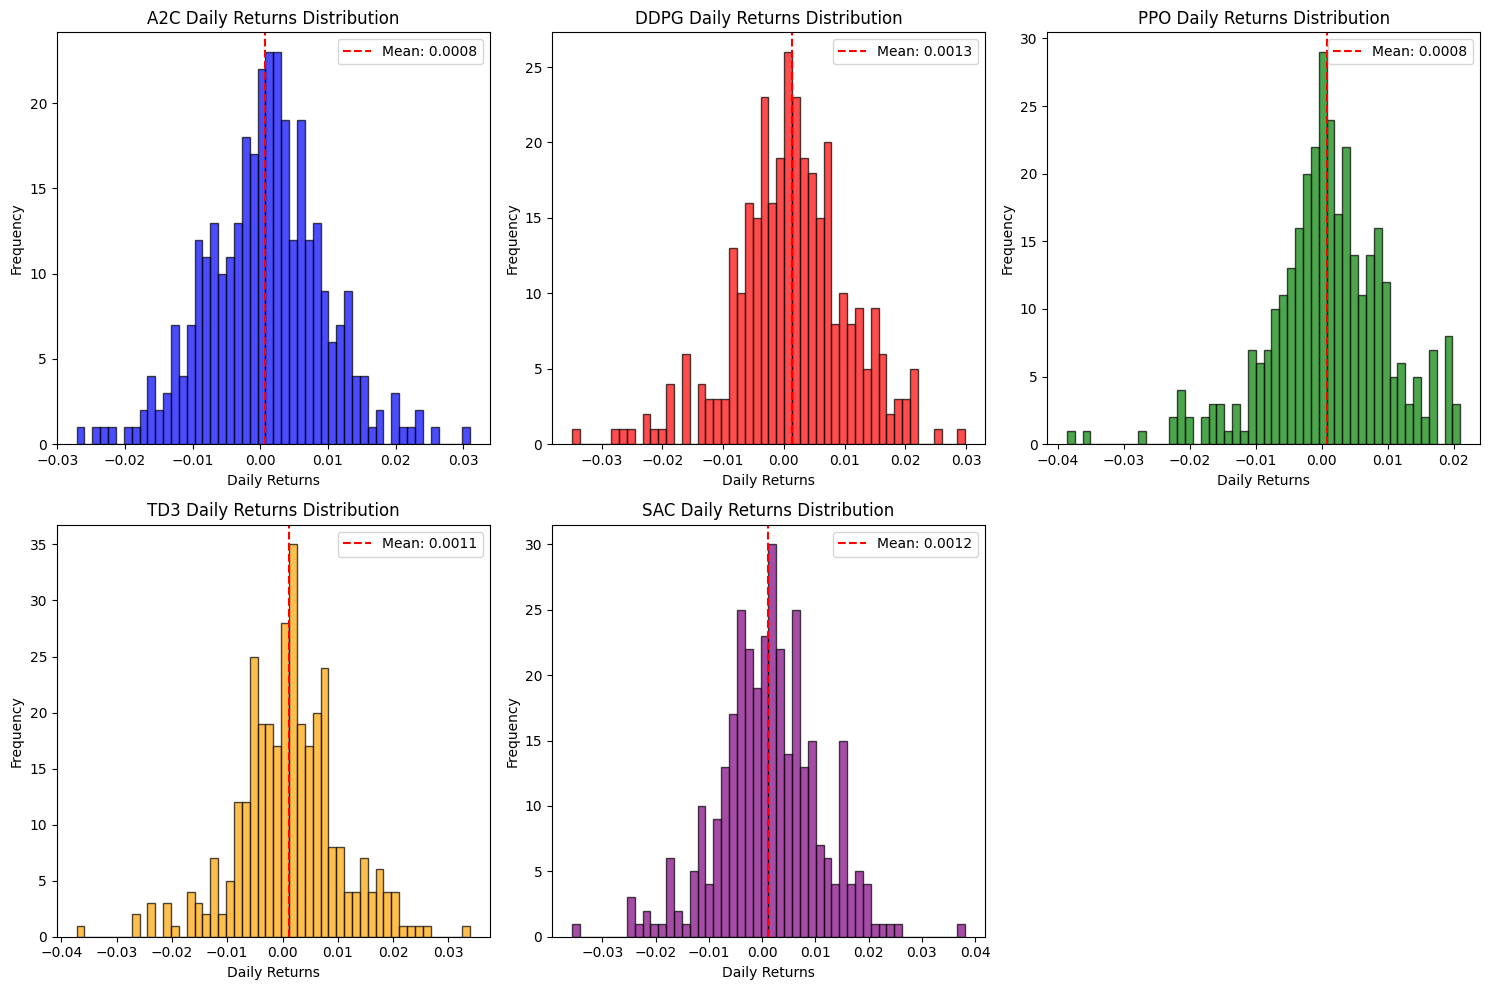

In [49]:
# 计算各模型的日收益率分布
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 10))

# 假设 df_account_value_xxx 是各模型的账户价值数据框
models = ['a2c', 'ddpg', 'ppo', 'td3', 'sac']
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, model in enumerate(models):
    if f'df_account_value_{model}' in globals():
        df = globals()[f'df_account_value_{model}']
        returns = df['account_value'].pct_change().dropna()

        plt.subplot(2, 3, i+1)
        plt.hist(returns, bins=50, alpha=0.7, color=colors[i], edgecolor='black')
        plt.title(f'{model.upper()} Daily Returns Distribution') # Changed to English
        plt.xlabel('Daily Returns') # Changed to English
        plt.ylabel('Frequency') # Changed to English
        plt.axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.4f}') # Changed to English
        plt.legend()

plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

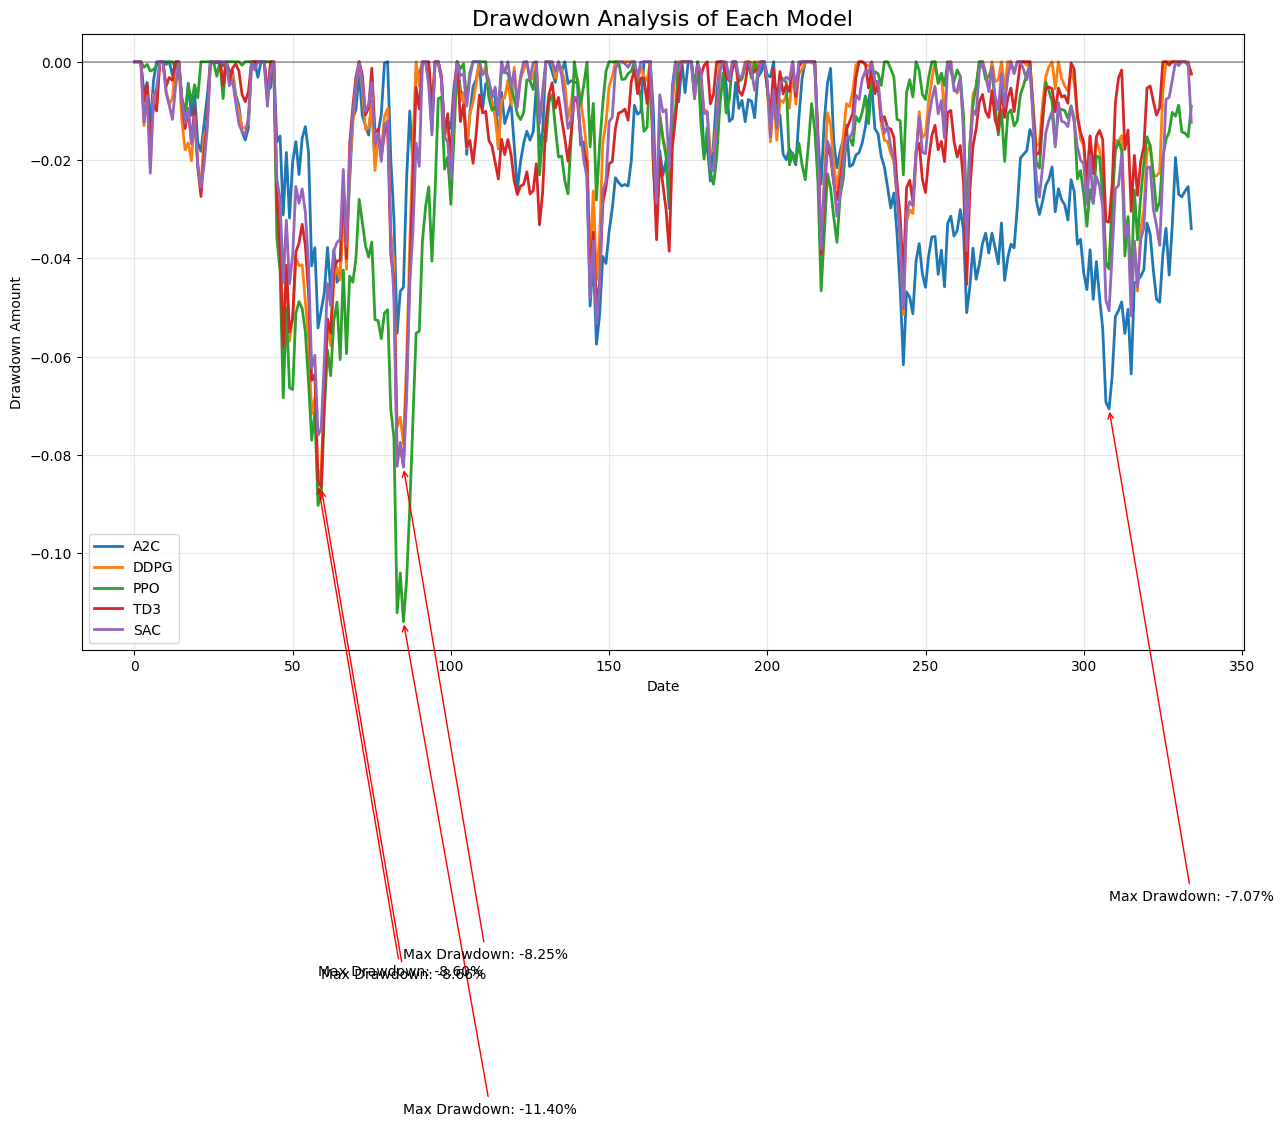

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [50]:
# 计算并绘制最大回撤
def calculate_drawdown(account_value):
    """计算最大回撤"""
    peak = account_value.expanding().max()
    drawdown = (account_value - peak) / peak
    return drawdown

plt.figure(figsize=(15, 8))

for model in models:
    if f'df_account_value_{model}' in globals():
        df = globals()[f'df_account_value_{model}']
        drawdown = calculate_drawdown(df['account_value'])

        plt.plot(drawdown.index, drawdown.values, label=f'{model.upper()}', linewidth=2)
        max_dd = drawdown.min()
        max_dd_date = drawdown.idxmin()
        plt.annotate(f'Max Drawdown: {max_dd:.2%}', # Changed to English
                    xy=(max_dd_date, max_dd),
                    xytext=(max_dd_date, max_dd-0.1),
                    arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Drawdown Analysis of Each Model', fontsize=16) # Changed to English
plt.xlabel('Date') # Changed to English
plt.ylabel('Drawdown Amount') # Changed to English
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.savefig('drawdown_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

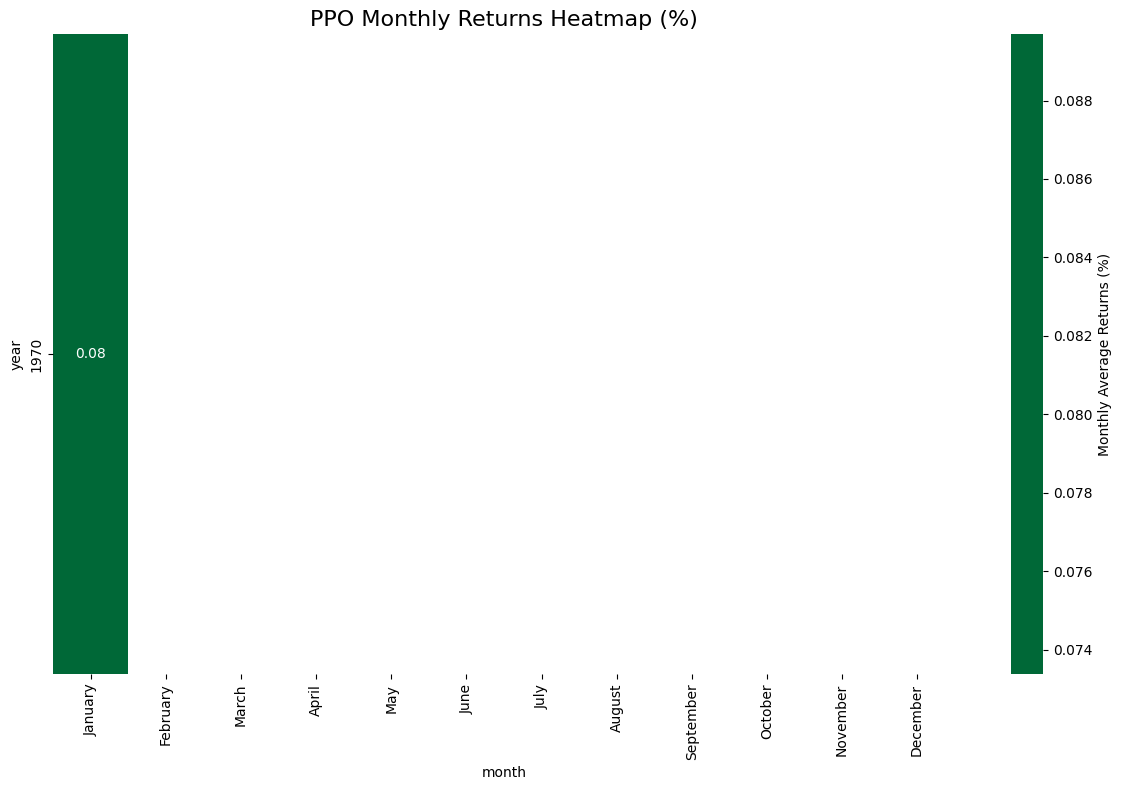

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [51]:
# 月度收益率热力图
def monthly_returns_heatmap(account_value, model_name):
    """生成月度收益率热力图"""
    returns = account_value['account_value'].pct_change().dropna()
    returns_df = pd.DataFrame(returns.values, index=returns.index, columns=['return'])
    returns_df.index = pd.to_datetime(returns_df.index)

    # 提取年月
    returns_df['year'] = returns_df.index.year
    returns_df['month'] = returns_df.index.month_name()

    # 创建数据透视表
    monthly_returns = returns_df.groupby(['year', 'month'])['return'].mean().unstack()

    # 确保月份顺序正确
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    monthly_returns = monthly_returns.reindex(columns=month_order)

    plt.figure(figsize=(12, 8))
    sns.heatmap(monthly_returns * 100, annot=True, fmt='.2f', cmap='RdYlGn',
                center=0, cbar_kws={'label': 'Monthly Average Returns (%)'}) # Changed to English
    plt.title(f'{model_name.upper()} Monthly Returns Heatmap (%)', fontsize=16) # Changed to English
    plt.tight_layout()
    plt.savefig(f'{model_name}_monthly_returns_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

# 为PPO模型生成热力图示例
if 'df_account_value_ppo' in globals():
    monthly_returns_heatmap(df_account_value_ppo, 'ppo')

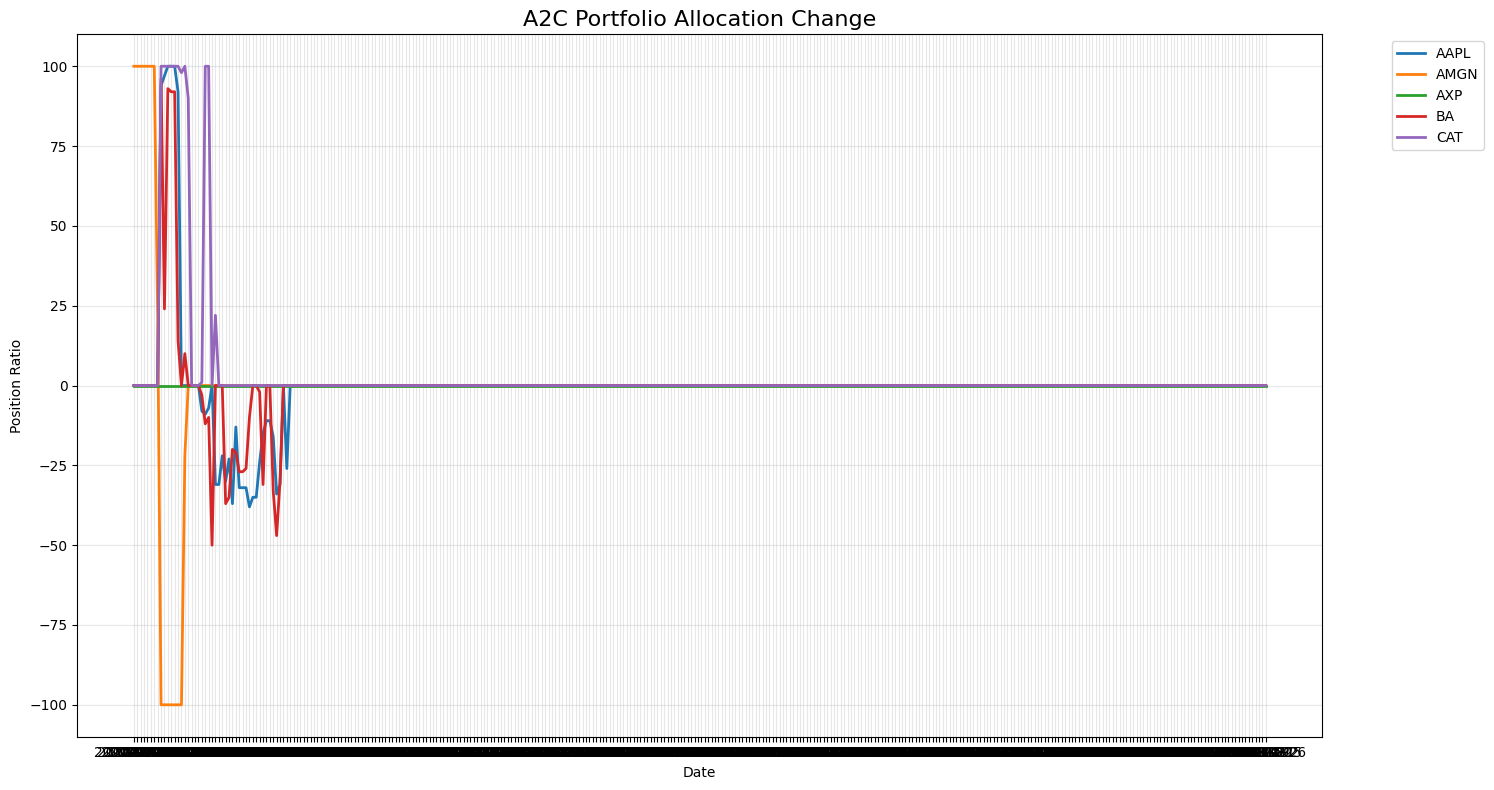

In [52]:
# 分析交易行为（持仓变化）
def plot_portfolio_allocation(df_actions, model_name):
    """绘制持仓分配变化"""
    if df_actions is not None:
        plt.figure(figsize=(15, 8))

        # 选择前5只股票展示（避免过于拥挤）
        stocks_to_plot = df_actions.columns[:5] if len(df_actions.columns) > 5 else df_actions.columns

        for stock in stocks_to_plot:
            plt.plot(df_actions.index, df_actions[stock], label=stock, linewidth=2)

        plt.title(f'{model_name.upper()} Portfolio Allocation Change', fontsize=16) # Changed to English
        plt.xlabel('Date') # Changed to English
        plt.ylabel('Position Ratio') # Changed to English
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{model_name}_portfolio_allocation.png', dpi=300, bbox_inches='tight')
        plt.show()

# 为A2C模型展示持仓变化
if 'df_actions_a2c' in globals():
    plot_portfolio_allocation(df_actions_a2c, 'a2c')

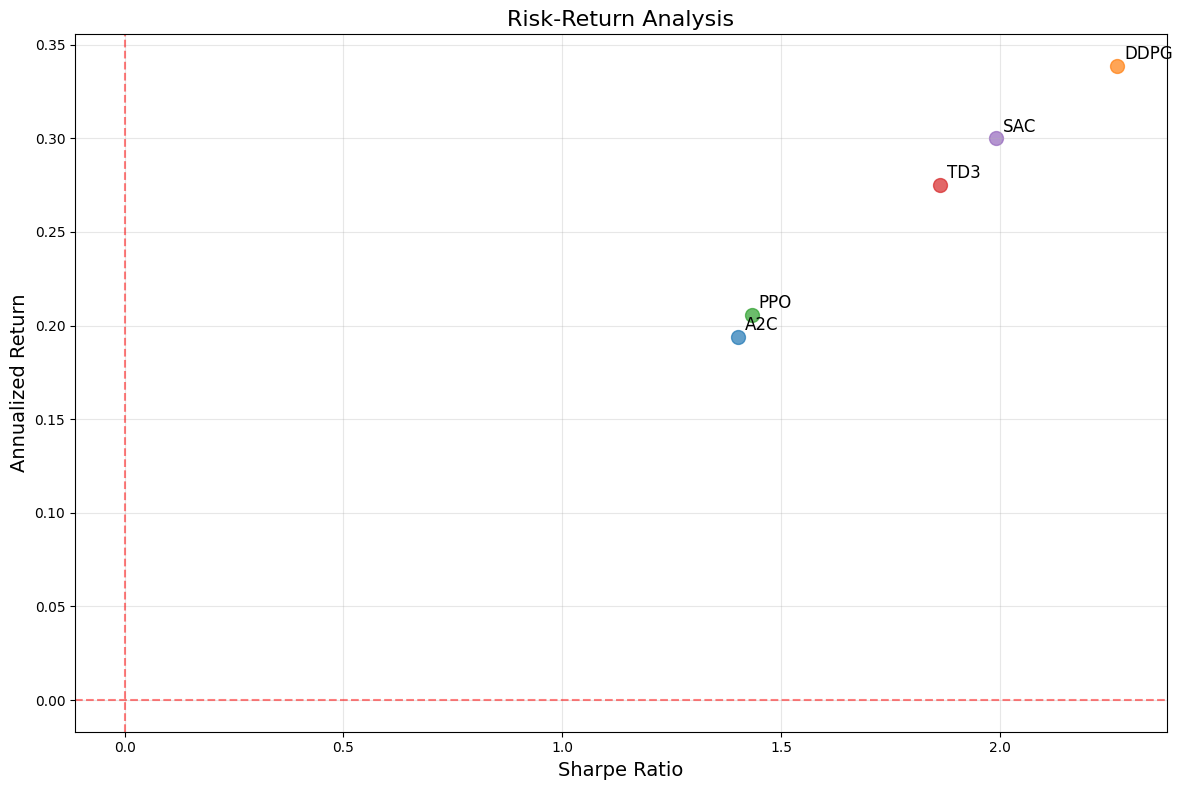

In [53]:
# 风险-收益散点图（夏普比率 vs 年化收益率）
plt.figure(figsize=(12, 8))

sharpes = []
annual_returns = []
model_names = []

for model in models:
    if f'df_account_value_{model}' in globals():
        df = globals()[f'df_account_value_{model}']
        returns = df['account_value'].pct_change().dropna()

        annual_return = returns.mean() * 252
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)

        sharpes.append(sharpe_ratio)
        annual_returns.append(annual_return)
        model_names.append(model.upper())

        plt.scatter(sharpe_ratio, annual_return, s=100, label=model.upper(), alpha=0.7)
        plt.annotate(model.upper(), (sharpe_ratio, annual_return),
                    xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Sharpe Ratio', fontsize=14) # Changed to English
plt.ylabel('Annualized Return', fontsize=14) # Changed to English
plt.title('Risk-Return Analysis', fontsize=16) # Changed to English
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('risk_return_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

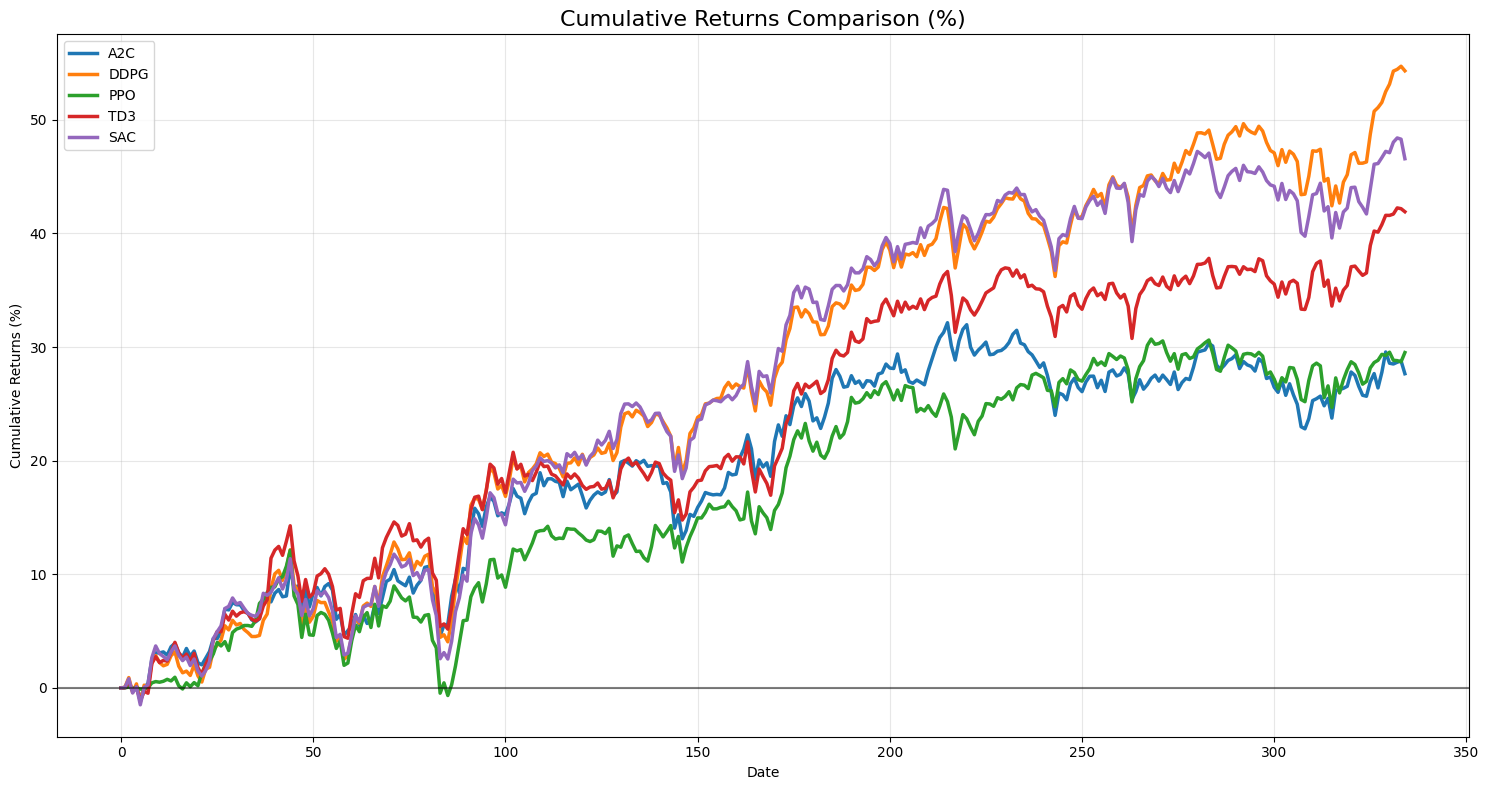

In [54]:
# 累积收益率对比
plt.figure(figsize=(15, 8))

for model in models:
    if f'df_account_value_{model}' in globals():
        df = globals()[f'df_account_value_{model}']
        cumulative_returns = (df['account_value'] / df['account_value'].iloc[0] - 1) * 100
        plt.plot(cumulative_returns.index, cumulative_returns.values,
                label=f'{model.upper()}', linewidth=2.5)

plt.title('Cumulative Returns Comparison (%)', fontsize=16) # Changed to English
plt.xlabel('Date') # Changed to English
plt.ylabel('Cumulative Returns (%)') # Changed to English
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.savefig('cumulative_returns_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# 下载所有新生成的可视化图表
from google.colab import files

charts = [
    'returns_distribution.png',
    'drawdown_analysis.png',
    'ppo_monthly_returns_heatmap.png',
    'a2c_portfolio_allocation.png',
    'risk_return_analysis.png',
    'cumulative_returns_comparison.png'
]

for chart in charts:
    try:
        files.download(chart)
        print(f"✅ 已下载: {chart}")
    except:
        print(f"❌ 未找到: {chart}")

print("所有图表下载完成！")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载: returns_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载: drawdown_analysis.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载: ppo_monthly_returns_heatmap.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载: a2c_portfolio_allocation.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载: risk_return_analysis.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载: cumulative_returns_comparison.png
所有图表下载完成！


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag